In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-failure-prediction/heart.csv


# 1.Data exploration and getting insights

In [2]:
data = pd.read_csv('../input/heart-failure-prediction/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.shape

(918, 12)

In [4]:
#Checking Dtypes
data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [5]:
#Checking MissingValues
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
categorical_features=['Sex','ChestPainType','FastingBS','RestingECG','ExerciseAngina','ST_Slope']
numerical_features= ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
target = ['HeartDisease']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


avg age = 54
avg age of disiease = 56


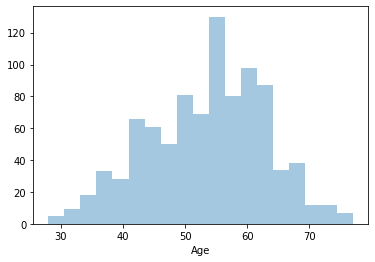

In [7]:
sns.distplot(a=data['Age'], kde=False)

avg_age = round(data['Age'].mean())

avg_heart_disease_age = round(data.loc[data["HeartDisease"]>0].Age.mean())

print(f'avg age = {avg_age}\navg age of disiease = {avg_heart_disease_age}')

Number of males = 725
Number of Females = 193

        
Number of affected males = 458
Number of affected females = 50

        
% of Male with disease= 63.17%
% of Female with disease= 25.91%



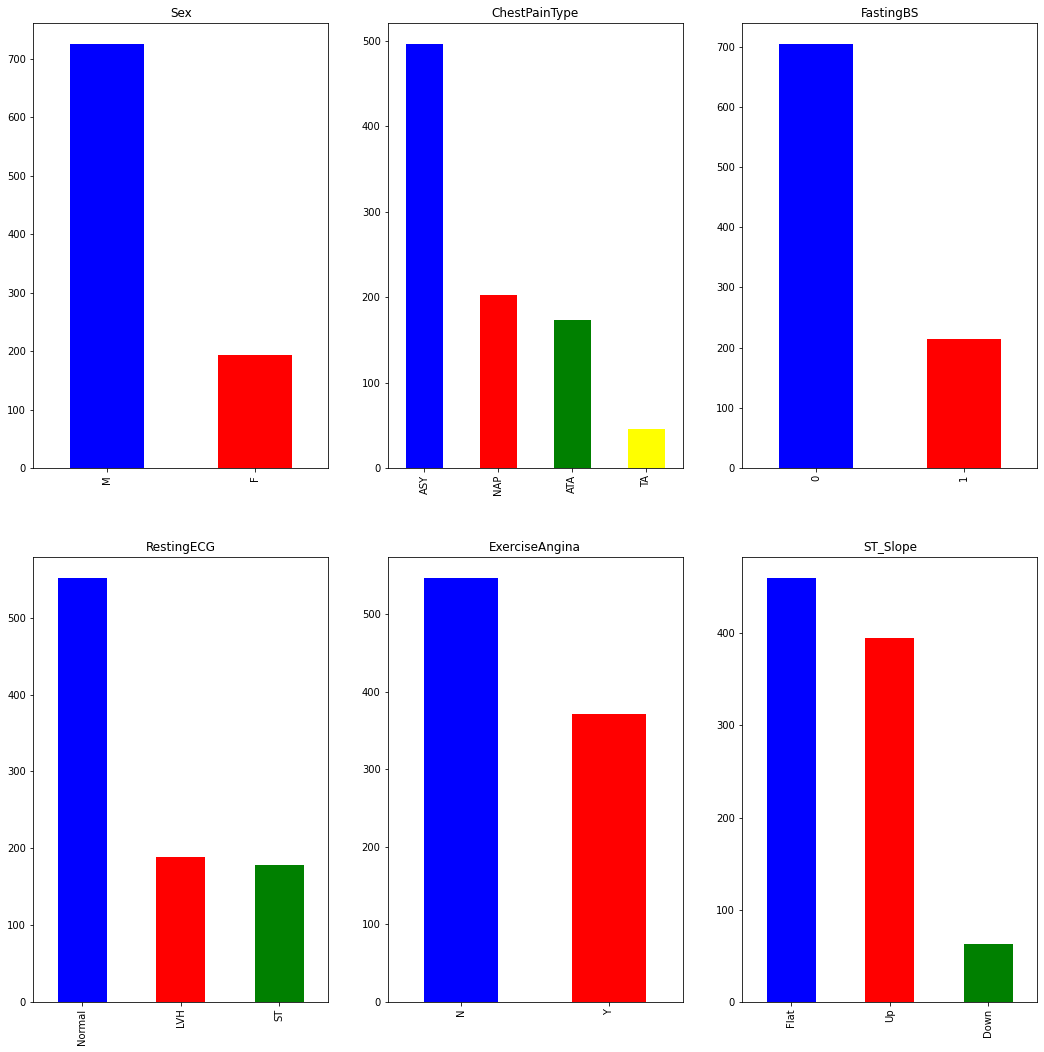

In [8]:
male = data.loc[data['Sex']=='M']
female = data.loc[data['Sex']=='F']

n_male = len(male)
n_female = len(female)

n_male_disease = len(male.loc[male["HeartDisease"]>0])
n_female_disease = len(female.loc[female["HeartDisease"]>0])

print(f'''Number of males = {n_male}\nNumber of Females = {n_female}\n
        \nNumber of affected males = {n_male_disease}\nNumber of affected females = {n_female_disease}\n
        \n% of Male with disease= {round(n_male_disease/n_male,4)*100}%\n% of Female with disease= {round(n_female_disease/n_female,4)*100}%\n''')

ROWS, COLS = 2, 3
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 18))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    data[categorical_feature].value_counts().plot(kind='bar', ax=ax[row, col],color=['blue', 'red', 'green', 'yellow']).set_title(categorical_feature)




The data set it's not balanced.
* There are more male samples than female, about 60% of males have a heart disease while about 25% of females do.
* There are significaly more cases of ASY chestpain types than the other three and very few of TA chestpain
* There are more samples of people that didn't do fasting.
* There are more people with normal RestingECG , but more or less the same amounts of the other two types.
* There are more people that didn't Excercise angina
* There is a significant lack of down ST_Slope values 

In [9]:
#creating a normalizeing value for Sex,which might be used later.Females will have higher values due to under representation.
male_normalized = 1 - n_male / len(data)
female_normalized = 1 - n_female / len(data)
data['SexNormalizer'] = 0
data.loc[data.Sex=='F','SexNormalizer']=female_normalized
data.loc[data.Sex=='M','SexNormalizer']=male_normalized
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease,SexNormalizer
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0,0.21024
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1,0.78976
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0,0.21024
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1,0.78976
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0,0.21024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1,0.21024
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1,0.21024
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1,0.21024
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1,0.78976


In [10]:
data[numerical_features].describe()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


<AxesSubplot:>

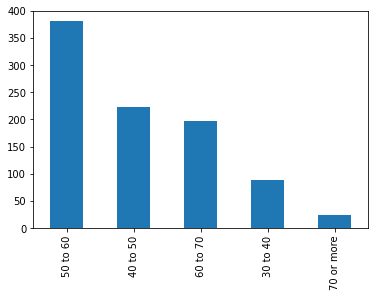

In [11]:
#Age group might be more usefull than age later on,dataset ages go up to 77 years old so I'll call the last category 70 or more in case the model recibes data from an 80+ patient.
data['Age_group'] = pd.cut(x=data['Age'], bins=[30, 40, 50, 60, 70, 80],
                            labels=['30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 or more'])

data['Age_group'].value_counts().plot(kind='bar')

Most of the samples age are around 50-60 years old

30 to 40      0.363636
40 to 50      0.417040
50 to 60      0.582677
60 to 70      0.736041
70 or more    0.666667
Name: Age_group, dtype: float64


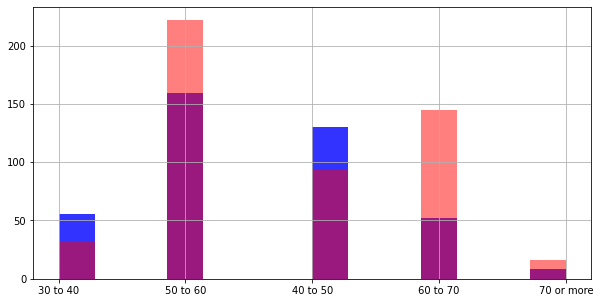

In [12]:
#Seeing how many of each group got a heath disease
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
data[data["HeartDisease"]<1]['Age_group'].hist(bins=14, color="blue", alpha=0.8)
data[data["HeartDisease"]>0]['Age_group'].hist(bins=14, color="red", alpha=0.5)

age_group_heart_desiease_ratio = data[data["HeartDisease"]>0]['Age_group'].value_counts()/data['Age_group'].value_counts()
print(age_group_heart_desiease_ratio)

From this graph we can get that people around 50 to 70+ years old are more propense into haveing a hearth disease. 70+ might be the least represented group but its second highest ratio of heart disease

array([<AxesSubplot:title={'center':'Age'}>,
       <AxesSubplot:title={'center':'RestingBP'}>,
       <AxesSubplot:title={'center':'Cholesterol'}>,
       <AxesSubplot:title={'center':'MaxHR'}>,
       <AxesSubplot:title={'center':'Oldpeak'}>], dtype=object)

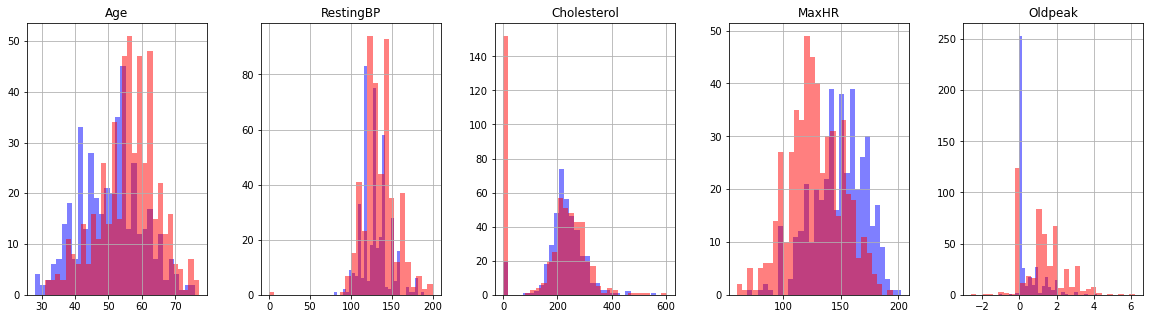

In [13]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
data[data["HeartDisease"]<1][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
data[data["HeartDisease"]>0][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

#### The blue color represents people who didn't got a hearth disease while red represents the oposite.
* People with a Max HearthRate bellow 150 were more likely to have a hearth disease
* Almost all people with an oldpeak diferent than 0 ,the further away from 0 the less likely to find people that didn't have a hearth disease.
* People who had Unhealthy levels of cholesterol (around 125-200 are the healthy levels of total cholesterol for adults) got higher chances of haveing a hearth disease, it seems some of the people show with 0 which its not possible, I'll replace them with median.
* People with a higher blood resting pressure got higher chances of getting a hearth disease(specially the ones that got between ~110-140), there are one or two with 0 blood pressure which basicaly means that the person is dead so I'll change them with median too.
* As for age it was discussed on previous cells. People of ages 50-70 were more propence to have a heath disease.

In [14]:
data['Cholesterol'] = data['Cholesterol'].apply(lambda x:data['Cholesterol'].median() if x==0 else x)
data['RestingBP'] = data['RestingBP'].apply(lambda x:data['RestingBP'].median() if x==0 else x)

array([<AxesSubplot:title={'center':'Age'}>,
       <AxesSubplot:title={'center':'RestingBP'}>,
       <AxesSubplot:title={'center':'Cholesterol'}>,
       <AxesSubplot:title={'center':'MaxHR'}>,
       <AxesSubplot:title={'center':'Oldpeak'}>], dtype=object)

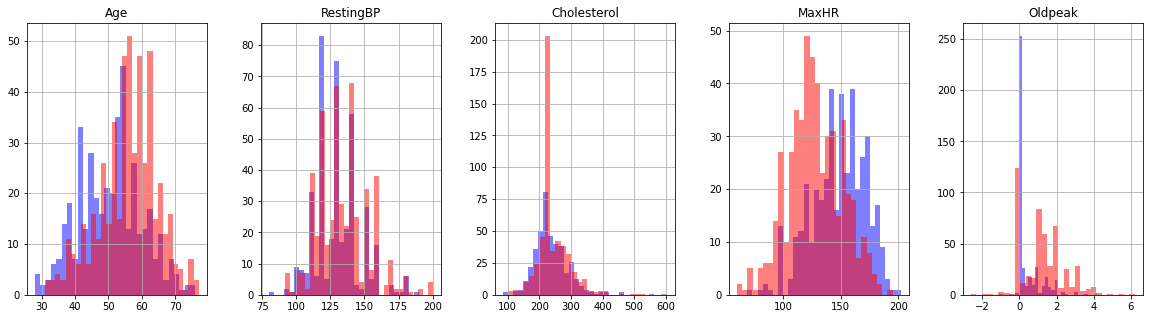

In [15]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
data[data["HeartDisease"]<1][numerical_features].hist(bins=30, color="blue", alpha=0.5, ax=ax)
data[data["HeartDisease"]>0][numerical_features].hist(bins=30, color="red", alpha=0.5, ax=ax)

<AxesSubplot:>

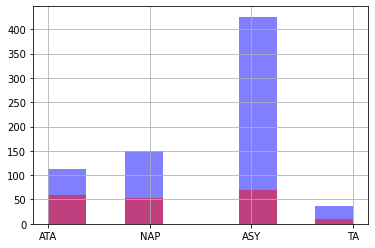

In [16]:
data[data['Sex']=='M']['ChestPainType'].hist(bins=8, color="blue", alpha=0.5)
data[data['Sex']=='F']['ChestPainType'].hist(bins=8, color="red", alpha=0.5)

Males seem to get more asyntomatic chest pains

In [17]:
male = data.loc[data['Sex']=='M']
female = data.loc[data['Sex']=='F']

<AxesSubplot:>

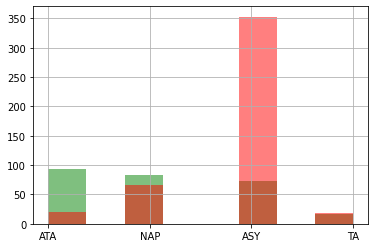

In [18]:
male[male["HeartDisease"]<1]['ChestPainType'].hist(bins=8, color="green", alpha=0.5)
male[male["HeartDisease"]>0]['ChestPainType'].hist(bins=8, color="red", alpha=0.5)

<AxesSubplot:>

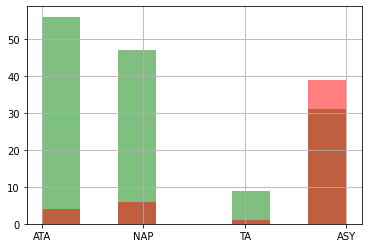

In [19]:
female[female["HeartDisease"]<1]['ChestPainType'].hist(bins=8, color="green", alpha=0.5)
female[female["HeartDisease"]>0]['ChestPainType'].hist(bins=8, color="red", alpha=0.5)

Asymtomatic chest pains seem to be the most dangerous for both male and female

<AxesSubplot:xlabel='Cholesterol', ylabel='Count'>

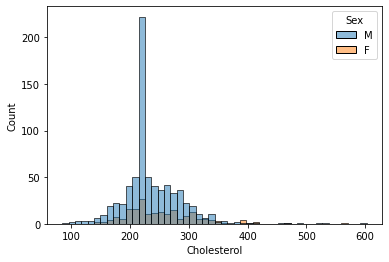

In [20]:
sns.histplot(data=data, x="Cholesterol", hue="Sex")

Males have more cholesterol levels than females

<AxesSubplot:xlabel='Cholesterol', ylabel='Count'>

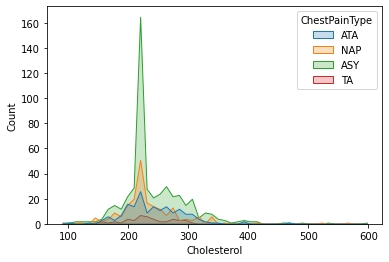

In [21]:
sns.histplot(data=data, x="Cholesterol", hue="ChestPainType", element="poly")